# Utils

In [1]:
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])


def mnist(batch_size=50, valid=0, shuffle=True, transform=mnist_transform, path='./MNIST_data'):
    test_data = datasets.MNIST(path, train=False, download=True, transform=transform)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    train_data = datasets.MNIST(path, train=True, download=True, transform=transform)
    if valid > 0:
        num_train = len(train_data)
        indices = list(range(num_train))
        split = num_train - valid
        np.random.shuffle(indices)

        train_idx, valid_idx = indices[:split], indices[split:]
        train_sampler = SubsetRandomSampler(train_idx)
        valid_sampler = SubsetRandomSampler(valid_idx)

        train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
        valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

        return train_loader, valid_loader, test_loader
    else:
        train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=shuffle)
        return train_loader, test_loader


def plot_mnist(images, shape): #рисуем мнист
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))
    plt.show()


def plot_graphs(log, tpe='loss'): #рисуем графики
    keys = log.keys()
    logs = {k: [z for z in zip(*log[k])] for k in keys}
    epochs = {k: range(len(log[k])) for k in keys}

    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

# Autoencoder

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# from utils import mnist, plot_graphs, plot_mnist, mnist_transform
import numpy as np

%matplotlib inline

In [3]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

train_loader, test_loader = mnist(batch_size=200, valid=0, transform=mnist_transform) #загружаем датасет

In [4]:
class Encoder(nn.Module): #энкодер - наследуемся от nn.model
    def __init__(self, latent_size=10):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(28*28, 1000)
        self.fc2 = nn.Linear(1000,600)
        self.fc3 = nn.Linear(600, latent_size)
    def forward(self, x):
        x1 = torch.tanh(self.fc1(x))
        x2 = torch.tanh(self.fc2(x1))
        x3 = torch.sigmoid(self.fc3(x2))
        return x3
    def first_layer(self, x):
        x1 = torch.tanh(self.fc1(x))
        return x1
class Decoder(nn.Module):#декодер - наследуемся от nn.model
    def __init__(self, latent_size=10):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_size, 1000)
        self.fc2 = nn.Linear(1000, 600)
        self.fc3 = nn.Linear(600, 28*28)
    def forward(self, x):
        x1 = torch.tanh(self.fc1(x))
        x2 = torch.tanh(self.fc2(x1))
        x3 = torch.tanh(self.fc3(x2))
        return x3

In [63]:
class Net(nn.Module):
    def __init__(self, latent_size=10, loss_fn=F.mse_loss, lr=1e-4, l2=0.): #задаем наш автоэнкодер
        super(Net, self).__init__()
        self.latent_size = latent_size
        self.E = Encoder(latent_size)
        self.D = Decoder(latent_size)
        self.loss_fn = loss_fn
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=lr, weight_decay=l2) #оптимизатор
        
    def forward(self, x):
        x = x.view(-1, 28*28) #превращаем картинку в вектор
        h = self.E(x) #превращаем данные в скрытое представление(h)
        out = self.D(h) #декодируем изображение
        return out
    
    def decode(self, h): #если задать сюда вектор правильной размерности, то его можно декодировать
        x = x.view(-1, 28*28)
        with torch.no_grad():
            return self.D(h)
    def encode(self, x): #если задать сюда вектор правильной размерности, то его можно декодировать
        x = x.view(-1, 28*28)
        with torch.no_grad():
            return self.E(x)
    def paint(self, x):
        x = x.view(-1, 28*28)
        with torch.no_grad():
            return self.E.first_layer(x)
    def loss(self, x, target, **kwargs):
        target = target.view(-1, 28*28)
        self._loss = self.loss_fn(x, target, **kwargs)
        return self._loss

In [64]:
models = {'16': Net(16), '32': Net(32), '64': Net(64)} #создание моделей
train_log = {k: [] for k in models} #создание лога
test_log = {k: [] for k in models} #создание лога

In [52]:
np.random.randint(4)

2

In [53]:
def add_noise(x, mode='crop', elementwise=False): #функция зашумления изображений
    if np.random.randint(2):
        return x
    x = x.clone() #копируем, чтобы не попортить оригинальные изображения
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2) * 2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            pass
        elif mode == 'gaussian':
            pass    
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2) * 2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x


In [54]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        noized = add_noise(data)
        for model in models.values():
            model.optim.zero_grad()
            output = model(noized)
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 150 == 0:
            line = 'Train Epoch: {} [{:05d}/{}] '.format(
                epoch, batch_idx * len(data), train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{:05d}/{}] '.format(
            epoch, batch_idx * len(data), train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append(models[k]._loss)
        print(line + losses)

In [55]:
avg_lambda = lambda l: 'loss: {:.4f}'.format(l)
line = lambda i, l: '{}: '.format(i) + avg_lambda(l)
    
def test(models, loader, log=None):
    test_size = len(loader.sampler)

    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            noized = add_noise(data)
            output = {k: m(noized) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data, reduction='sum').item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= (test_size * 784)
        if log is not None:
            log[k].append(test_loss[k])
    
    lines = '\n'.join([line(k, test_loss[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines        
    print(report)

In [56]:
data, _ = next(iter(test_loader))
noized = add_noise(data, elementwise=True)
output = models['64'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

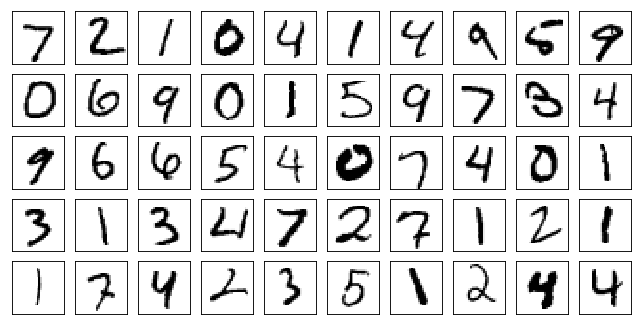

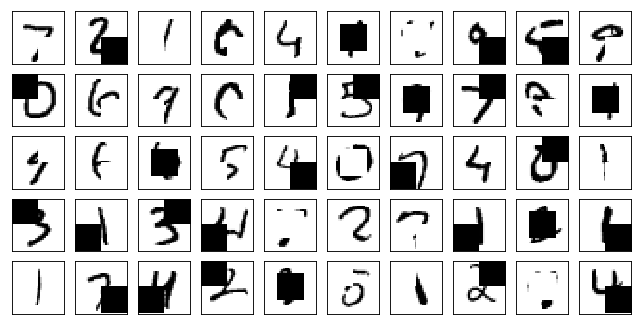

In [57]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))

In [58]:
for epoch in range(1, 2):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 16: 0.943840 32: 0.933724 64: 0.935061
Train Epoch: 1 [30000/60000] 16: 0.267812 32: 0.267761 64: 0.267744
Train Epoch: 1 [60000/60000] 16: 0.263304 32: 0.267567 64: 0.265547
Test set:
16: loss: 0.2595
32: loss: 0.2641
64: loss: 0.2621



In [59]:
data, _ = next(iter(test_loader))
noized = add_noise(data, elementwise=True)
output = models['64'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

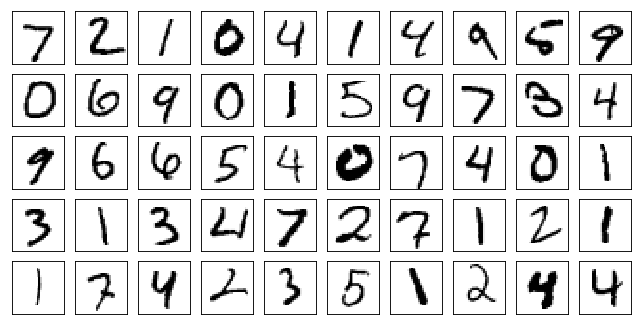

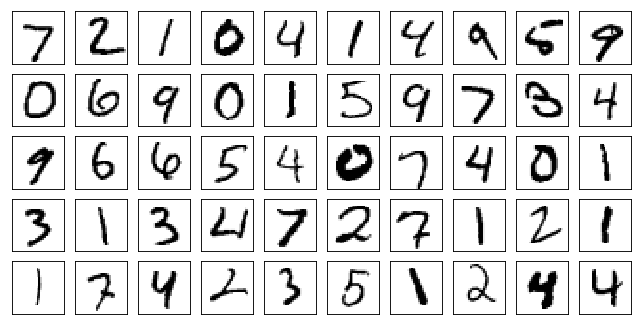

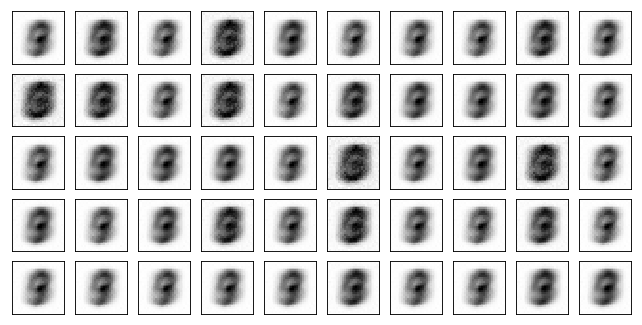

In [60]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

# Многослойный автокодировщик с отображениями

In [103]:
models = {'2': Net(2), '32': Net(32)} #создание моделей
train_log = {k: [] for k in models} #создание лога
test_log = {k: [] for k in models} #создание лога

In [104]:
for epoch in range(1, 28):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_loader, test_log)

Train Epoch: 1 [00000/60000] 2: 0.939101 32: 0.933507
Train Epoch: 1 [30000/60000] 2: 0.261560 32: 0.261385
Train Epoch: 1 [60000/60000] 2: 0.258874 32: 0.265787
Test set:
2: loss: 0.2626
32: loss: 0.2698

Train Epoch: 2 [00000/60000] 2: 0.266429 32: 0.266815
Train Epoch: 2 [30000/60000] 2: 0.244761 32: 0.245167
Train Epoch: 2 [60000/60000] 2: 0.245624 32: 0.223220
Test set:
2: loss: 0.2375
32: loss: 0.2248

Train Epoch: 3 [00000/60000] 2: 0.233699 32: 0.219250
Train Epoch: 3 [30000/60000] 2: 0.226620 32: 0.199779
Train Epoch: 3 [60000/60000] 2: 0.221259 32: 0.183795
Test set:
2: loss: 0.2216
32: loss: 0.1748

Train Epoch: 4 [00000/60000] 2: 0.218513 32: 0.168323
Train Epoch: 4 [30000/60000] 2: 0.222053 32: 0.159218
Train Epoch: 4 [60000/60000] 2: 0.212460 32: 0.146270
Test set:
2: loss: 0.2152
32: loss: 0.1603

Train Epoch: 5 [00000/60000] 2: 0.212030 32: 0.153785
Train Epoch: 5 [30000/60000] 2: 0.212812 32: 0.144075
Train Epoch: 5 [60000/60000] 2: 0.214279 32: 0.141461
Test set:
2: l

# Обучим 2 модели - на 2 и 32 скрытый слой

In [105]:
from sklearn.manifold import TSNE

In [106]:
data, true_digits = next(iter(test_loader))
noized = add_noise(data, elementwise=True)
output = models['32'](noized[:150])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

In [107]:
output1 = models['2'].encode(noized[:150])
output2 = models['32'].encode(noized[:150])
output2= TSNE(n_components=2).fit_transform(output2)

In [108]:
x1 = []
y1 = []
x2 = []
y2 = []
output2 = output2.tolist()
label = true_digits.tolist()

colors = ['red','green','blue','purple', 'yellow', 'pink', 'black', 'violet', 'orange', 'navy']
for count, value in enumerate(output1):
    x1.append(float(value[0]))
    y1.append(float(value[1]))
for count, value in enumerate(output2):
    x2.append(float(value[0]))
    y2.append(float(value[1]))

In [185]:
data, _ = next(iter(test_loader))
noized = add_noise(data, elementwise=True)
output = models['32'](noized[:50])
to_plot = output.view(-1, 1, 28, 28).data.numpy()

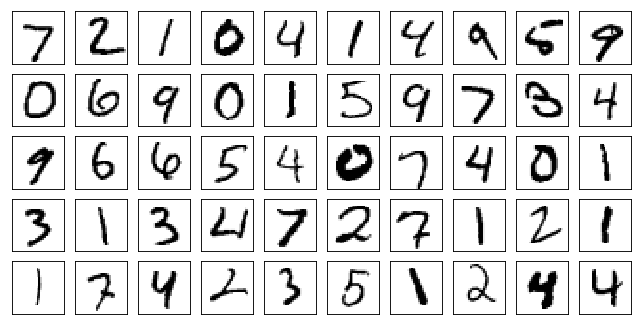

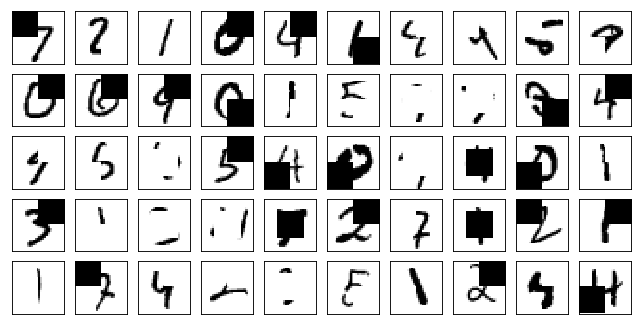

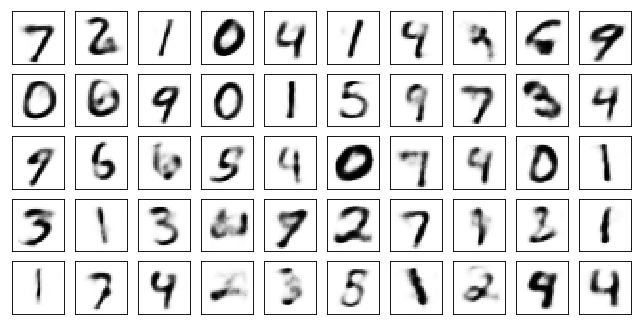

In [186]:
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))
plot_mnist(to_plot, (5, 10))

# Визуализируем, что получилось 

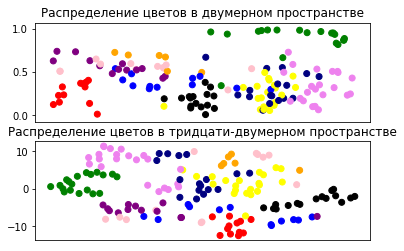

In [109]:
fig, axes = plt.subplots(2, 1)
axes[0].scatter(x1, y1, c = label[:150],cmap=matplotlib.colors.ListedColormap(colors))
axes[0].set_title('Распределение цветов в двумерном пространстве')
axes[0].set_xticks([])

axes[1].scatter(x2, y2, c = label[:150],cmap=matplotlib.colors.ListedColormap(colors))
axes[1].set_title('Распределение цветов в тридцати-двумерном пространстве')
axes[1].set_xticks([])
plt.show()

# Теперь "пошумим, **ть!" - добавим шумы

In [110]:
def add_noise_upgrade(x, mode='crop', elementwise=False): #функция зашумления изображений
    if np.random.randint(2):
        return x
    x = x.clone() #копируем, чтобы не попортить оригинальные изображения
    if elementwise:
        if mode == 'crop':
            for i in range(x.shape[0]):
                img_part = np.random.randint(5)
                zero_one = np.random.randint(2) * 2 - 1
                if img_part == 0:
                    x[i, :, :14, :14] = zero_one
                elif img_part == 1:
                    x[i, :, :14, 14:] = zero_one
                elif img_part == 2:
                    x[i, :, 14:, :14] = zero_one
                elif img_part == 3:
                    x[i, :, 14:, 14:] = zero_one
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = zero_one
        elif mode == 'mirror':
            for i in range(x.shape[0]):
                img_part = np.random.randint(4)
                if img_part == 0:
                    mask = x[i, :, :14, :14] 
                    mask = mask.flip([0,1])
                    x[i, :, :14, :14] = mask
                elif img_part == 1:
                    mask = x[i, :, :14, 14:] 
                    mask = mask.flip([0,1])
                    x[i, :, :14, 14:] = mask
                elif img_part == 2:
                    mask = x[i, :, 14:, :14]
                    mask = mask.flip([0,1])
                    x[i, :, 14:, :14] = mask
                elif img_part == 3:
                    mask = x[i, :, 14:, 14:] 
                    mask = mask.flip([0,1])
                    x[i, :, 14:, 14:] = mask
        
        elif mode == 'gaussian':
            for i in range(x.shape[0]):
                noise = np.random.normal(0,1,14)
                img_part = np.random.randint(5)
                if img_part == 0:
                    x[i, :, :14, :14] =  x[i, :, :14, :14]*noise
                elif img_part == 1:
                    x[i, :, :14, 14:] = x[i, :, :14, 14:]*noise
                elif img_part == 2:
                    x[i, :, 14:, :14] = x[i, :, 14:, :14]*noise
                elif img_part == 3:
                    x[i, :, 14:, 14:] = x[i, :, 14:, 14:]*noise
                elif img_part == 4:
                    x[i, :, 7:21, 7:21] = x[i, :, 7:21, 7:21]*noise
        
    else:
        if mode == 'crop':
            img_part = np.random.randint(5)
            zero_one = np.random.randint(2) * 2 - 1
            if img_part == 0:
                x[:, :, :14, :14] = zero_one
            elif img_part == 1:
                x[:, :, :14, 14:] = zero_one
            elif img_part == 2:
                x[:, :, 14:, :14] = zero_one
            elif img_part == 3:
                x[:, :, 14:, 14:] = zero_one
            elif img_part == 4:
                x[:, :, 7:21, 7:21] = zero_one
    return x

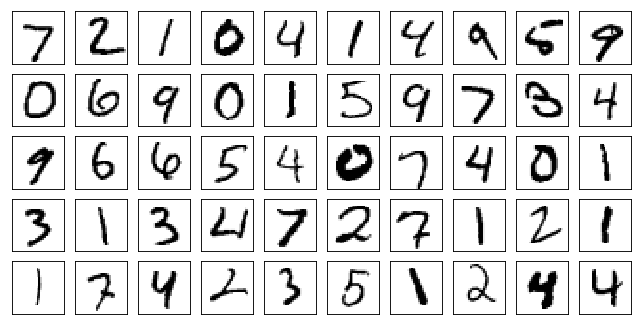

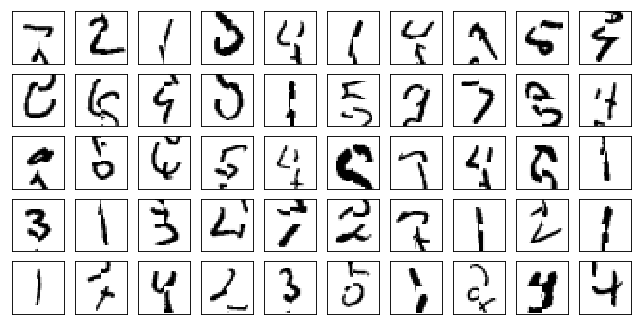

In [111]:
noized = add_noise_upgrade(data,mode='mirror', elementwise=True)
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))

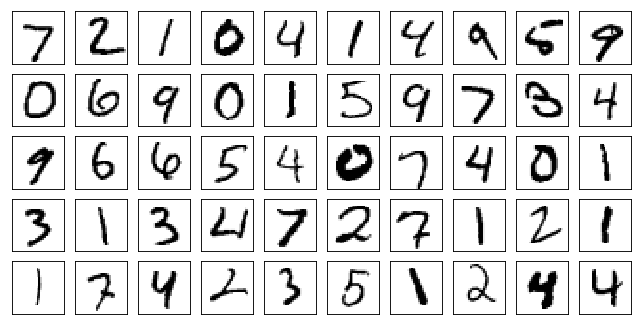

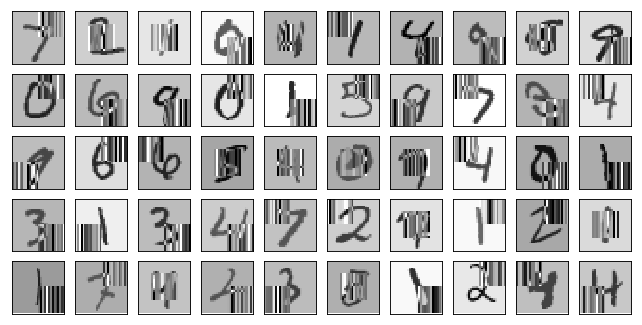

In [184]:
noized = add_noise_upgrade(data,mode='gaussian', elementwise=True)
plot_mnist(data.data.numpy()[:50], (5, 10))
plot_mnist(noized[:50], (5, 10))

## Снова порисуем

In [180]:
def lets_paint_first_layer(x):
    x = output2.tolist()
    z = []
    zu = []
    q = 1
    for i in x[0]:
        if i > 0:
            z.append(1)
        else:
            z.append(0)
        zu.append(q)
        q +=1
    y = [1 for i in range(len(x[0]))]
    colors = ['red','blue']
    fig, axes = plt.subplots(1, 1)
    axes.scatter(zu, y, c =z,cmap=matplotlib.colors.ListedColormap(colors))
    axes.set_title('Активация нейронов первого слоя')
    axes.set_xticks([])

    plt.show()

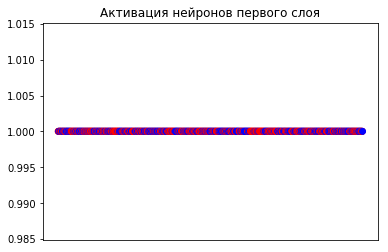

In [181]:
lets_paint_first_layer(models['32'].paint(noized[:150]))